In [119]:
import cplex
import sys
from docplex.cp.model import *
import pandas as pd
import numpy as np

In [120]:
url = 'https://api-oaas.docloud.ibmcloud.com/job_manager/rest/v1/'
key = 'api_4672a762-20f8-4eff-a739-bac6b6aa4134'

In [121]:
dpath = 'C:/Users/LUQI/informs/data/'
df1 = pd.read_csv(dpath +"process_schedule.csv")
df2 = pd.read_csv(dpath +"process_dict.csv")

In [122]:
# Number of batches simulated
NbBatches = 2;
Batches = range(NbBatches)
mdl = CpoModel()

In [123]:
# Define TankNames
TankNames = df1['TankNames'].tolist()

TankNames = list(set(TankNames))

In [125]:
# Define TaskNames
TaskNames = df2['Tasknames'].tolist()

In [126]:
#Define Duration
Duration = df2['Duration'].tolist()

In [128]:
#Define Tanks & Tasks
Tanks = dict(zip(df2['Tasknames'],df2['TankNames']))

In [130]:
# Define precedences

Precedences = set()


pre = df1['Predecessor'].tolist()

for i in range(len(pre)):
    if 'None' in pre:
        pre.remove('None')
        
tempTask = list()

for i in range(len(df1)):
    if df1.iat[i,3] != "None":
        tempTask.append(df1.iat[i,1])


for k in range(len(tempTask)):
    Precedences.add((pre[k],tempTask[k]))

In [132]:
# Define State

State = set()


pre1 = df2['State'].tolist()

for i in range(len(pre1)):
    if 'None' in pre1:
        pre1.remove('None')
        
tempTask1 = list()

for i in range(len(df2)):
    if df2.iat[i,3] != "None":
        tempTask1.append(df2.iat[i,1])


for k in range(len(tempTask1)):
    State.add((tempTask1[k],pre1[k]))

In [134]:
AllStates = ["BR","AR"]
Index = {s : i for i,s in enumerate(AllStates)}
AllStates

['BR', 'AR']

In [135]:
ttime = CpoTransitionMatrix(name='TTime',size=2)
ttime.set_value(Index["BR"], Index["AR"], 2)
ttime.set_value(Index["AR"], Index["BR"], 0)

In [136]:
state = { b : state_function(ttime, name="batch"+str(b)) for b in Batches}

In [137]:
# Define Maintenance Break
Breaks = {
    "TK3606": [(50,55),(155,160)],
    "TK4502":[(50,55),(155,160)],
    "TK3406":[(85,90),(200,205)],
    "TK4801A":[(85,90),(200,205)],
    "TK4701":[(85,90),(200,205)],
    "TK3503":[(85,90),(200,205)],
    "TK3603":[(50,55),(155,160)],
    "TK4901":[(50,55),(155,160)],
    "TK3407":[(50,55),(155,160)],
    "TK4803A":[(85,90),(200,205)],
    "TK3605":[(50,55),(155,160)],
    "TK4802A":[(80,90),(200,210)]   
}

In [138]:
from collections import namedtuple
Break = namedtuple('Break', ['start', 'end'])

In [139]:
# Define Calendar
Calendar = {}
mymax = max(max(v for k,v in Breaks[w]) for w in TankNames)
for w in TankNames:
    step = CpoStepFunction()
    step.set_value(0, mymax, 100)
    for b in Breaks[w]:
        t = Break(*b)
        step.set_value(t.start, t.end, 0)
    Calendar[w] = step

In [141]:
itvs = {}
for b in Batches:
    for i,t in enumerate(TaskNames):
        _name = str(b) + "_" + str(t)
        itvs[(b,t)] = mdl.interval_var(size=Duration[i],intensity=Calendar[Tanks[t]],name=_name)

In [142]:
for b in Batches:
    for p in Precedences:
        mdl.add( mdl.end_before_start(itvs[b,p[0]], itvs[b,p[1]]) )

    for s in State:
        mdl.add( mdl.always_equal(state[b], itvs[b,s[0]], Index[s[1]]) )

In [144]:
for b in Batches:
    for p in Precedences:
        mdl.add(mdl.end_before_start(itvs[b,p[0]], itvs[b,p[1]]) )

In [145]:
for w in TankNames:
    mdl.add( mdl.no_overlap( [itvs[b,t] for b in Batches for t in TaskNames if Tanks[t]==w]  ) )

In [146]:
for b in Batches:
    for t in TaskNames:
        mdl.add(mdl.forbid_start(itvs[b,t], Calendar[Tanks[t]]))
        mdl.add(mdl.forbid_end (itvs[b,t], Calendar[Tanks[t]]))

In [147]:
mdl.add( mdl.minimize(mdl.max(mdl.end_of(itvs[b,'2UO16_A']) for b in Batches)))

In [148]:
# Solve the model
print("\nSolving model....")
msol1 = mdl.solve(url=url, key=key, FailLimit=30000)
print("done")


Solving model....
done


In [149]:
msol1.get_objective_values()

(172,)

In [150]:
print(msol1.get_objective_values())

(172,)


In [151]:
print("Duration will be "+str( msol1.get_objective_values()[0]))

Duration will be 172


In [152]:
# Allocate tasks to Tanks
tasks = {w : [] for w in TankNames}
for k,v in Tanks.items():
    tasks[v].append(k)

types = {t : i for i,t in enumerate(TaskNames)}

In [155]:
import docplex.cp.utils_visu as visu
import matplotlib.pyplot as plt
%matplotlib inline
#Change the plot size
from pylab import rcParams
rcParams['figure.figsize'] = 30,15

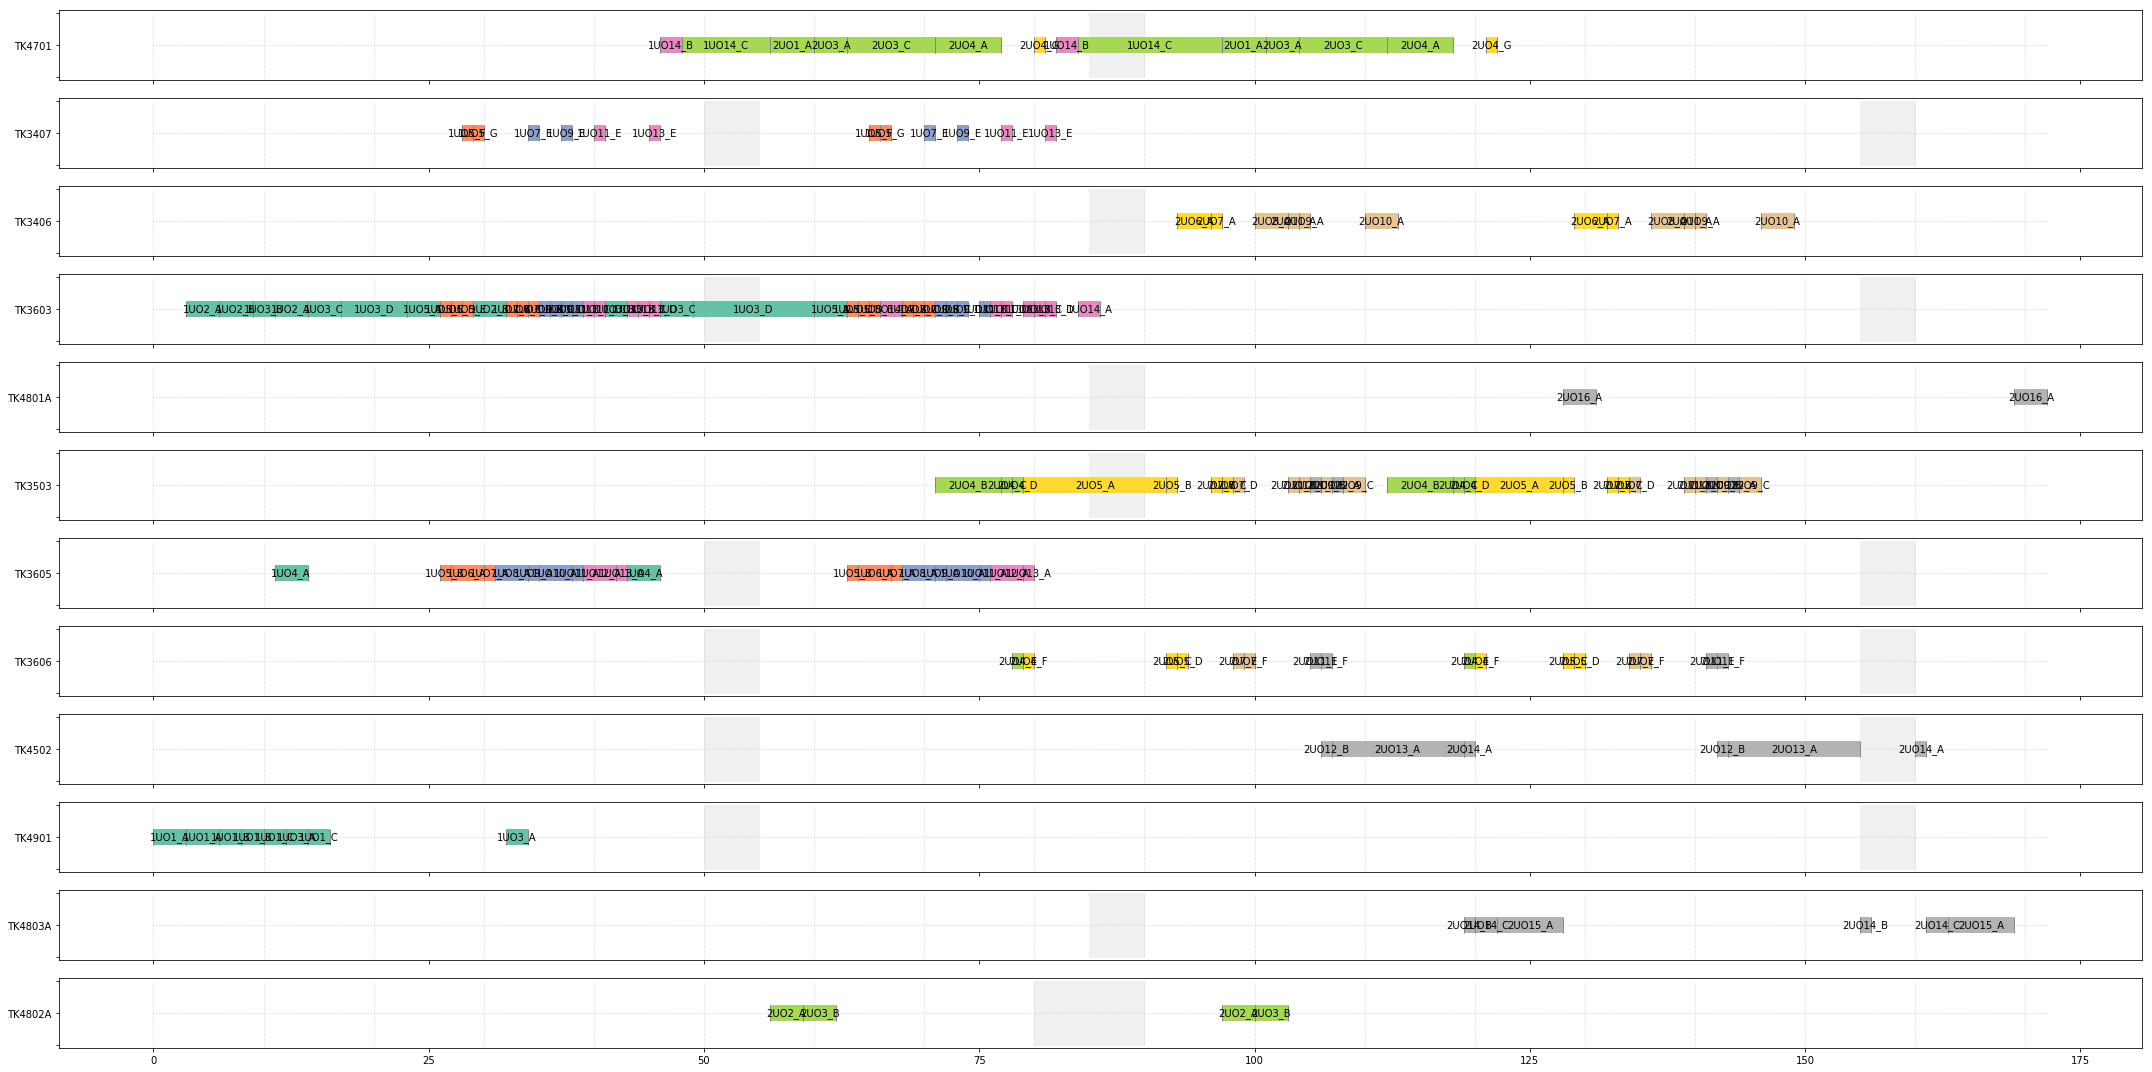

In [156]:
visu.timeline('Solution SchedCalendar')
for w in TankNames:
    visu.panel()
    visu.pause(Calendar[w])
    visu.sequence(name=w,
                  intervals=[(msol1.get_var_solution(itvs[b,t]), types[t], t) for t in tasks[w] for b in Batches])
visu.show()

In [157]:
a = 0
for i in itvs:
    a+=1
    var_sol = [(msol1.get_var_solution(itvs[b,t]), types[t], t) for t in tasks[w] for b in Batches]
    #print("{} : {}..{}".format(var_sol.get_start(), var_sol.get_end()))
    print(var_sol[0])
    for k in var_sol:
        #for j in k:
        print("{} : {}..{}".format(str(k[0])[0:12],k[0].get_start(), k[0].get_end()))
print(a)

(<docplex.cp.solution.CpoIntervalVarSolution object at 0x00000244B9575FC0>, 45, '2UO2_A')
0_2UO2_A: (s : 97..100
1_2UO2_A: (s : 56..59
0_2UO3_B: (s : 100..103
1_2UO3_B: (s : 59..62
(<docplex.cp.solution.CpoIntervalVarSolution object at 0x00000244B9575FC0>, 45, '2UO2_A')
0_2UO2_A: (s : 97..100
1_2UO2_A: (s : 56..59
0_2UO3_B: (s : 100..103
1_2UO3_B: (s : 59..62
(<docplex.cp.solution.CpoIntervalVarSolution object at 0x00000244B9575FC0>, 45, '2UO2_A')
0_2UO2_A: (s : 97..100
1_2UO2_A: (s : 56..59
0_2UO3_B: (s : 100..103
1_2UO3_B: (s : 59..62
(<docplex.cp.solution.CpoIntervalVarSolution object at 0x00000244B9575FC0>, 45, '2UO2_A')
0_2UO2_A: (s : 97..100
1_2UO2_A: (s : 56..59
0_2UO3_B: (s : 100..103
1_2UO3_B: (s : 59..62
(<docplex.cp.solution.CpoIntervalVarSolution object at 0x00000244B9575FC0>, 45, '2UO2_A')
0_2UO2_A: (s : 97..100
1_2UO2_A: (s : 56..59
0_2UO3_B: (s : 100..103
1_2UO3_B: (s : 59..62
(<docplex.cp.solution.CpoIntervalVarSolution object at 0x00000244B9575FC0>, 45, '2UO2_A')
0_2UO

0_2UO2_A: (s : 97..100
1_2UO2_A: (s : 56..59
0_2UO3_B: (s : 100..103
1_2UO3_B: (s : 59..62
(<docplex.cp.solution.CpoIntervalVarSolution object at 0x00000244B9575FC0>, 45, '2UO2_A')
0_2UO2_A: (s : 97..100
1_2UO2_A: (s : 56..59
0_2UO3_B: (s : 100..103
1_2UO3_B: (s : 59..62
(<docplex.cp.solution.CpoIntervalVarSolution object at 0x00000244B9575FC0>, 45, '2UO2_A')
0_2UO2_A: (s : 97..100
1_2UO2_A: (s : 56..59
0_2UO3_B: (s : 100..103
1_2UO3_B: (s : 59..62
(<docplex.cp.solution.CpoIntervalVarSolution object at 0x00000244B9575FC0>, 45, '2UO2_A')
0_2UO2_A: (s : 97..100
1_2UO2_A: (s : 56..59
0_2UO3_B: (s : 100..103
1_2UO3_B: (s : 59..62
(<docplex.cp.solution.CpoIntervalVarSolution object at 0x00000244B9575FC0>, 45, '2UO2_A')
0_2UO2_A: (s : 97..100
1_2UO2_A: (s : 56..59
0_2UO3_B: (s : 100..103
1_2UO3_B: (s : 59..62
(<docplex.cp.solution.CpoIntervalVarSolution object at 0x00000244B9575FC0>, 45, '2UO2_A')
0_2UO2_A: (s : 97..100
1_2UO2_A: (s : 56..59
0_2UO3_B: (s : 100..103
1_2UO3_B: (s : 59..62
(<do

In [188]:
print(len(TaskNames))
from datetime import datetime

date = datetime.strptime('01 01 2020', '%d %m %Y')
#newdate = date.replace(hour=11, minute=59)
dictList = list()
for k in range(NbBatches):
    
    for i in range(len(TaskNames)):
        date = datetime.strptime('01 01 2020', '%d %m %Y')
        if msol1.get_var_solution(itvs[(k, TaskNames[i])]).get_start() > 24:
            day = int(msol1.get_var_solution(itvs[(k, TaskNames[i])]).get_start()/24)
            hour = int(msol1.get_var_solution(itvs[(k, TaskNames[i])]).get_start()%24)
            startdate = date.replace(day = day, hour=hour)
        else:
            startdate = date.replace(hour=msol1.get_var_solution(itvs[(k, TaskNames[i])]).get_start())
        
        if msol1.get_var_solution(itvs[(k, TaskNames[i])]).get_end() > 24:
            day = int(msol1.get_var_solution(itvs[(k, TaskNames[i])]).get_end()/24)
            hour = int(msol1.get_var_solution(itvs[(k, TaskNames[i])]).get_end()%24)
            enddate = date.replace(day = day, hour=hour)
        else:
            enddate = date.replace(hour=msol1.get_var_solution(itvs[(k, TaskNames[i])]).get_end())    
            
        
        dictList.append(dict(Task=TaskNames[i], Start=startdate, Finish=enddate, Batch = k+1, Resource=Tanks[TaskNames[i]]))
    

86


In [189]:
import pandas as pd

data = pd.DataFrame(dictList)

In [190]:
data.to_csv('Schedule_Report.csv')

In [186]:
import plotly.figure_factory as ff

dpath = 'C:/Users/LUQI/informs/data/'
df3 = pd.read_csv(dpath +"gantt_chart_data.csv")

colors = dict(Batch_1='rgb(220, 0, 0)', Batch_2='rgb(170, 14, 200)')

fig = ff.create_gantt(df3, colors = colors, index_col='Resource', group_tasks=True,show_colorbar=True,
                      bar_width=0.6, showgrid_x=True, showgrid_y=True,title='Simulated Production Schedule')
fig.show()

In [187]:
import plotly as plotly
plotly.offline.plot(fig,filename = "gantt_chart.html")

'gantt_chart.html'